In [2]:
import numpy as np
import pandas as pd
import subprocess
import os
import csv
import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

def generate_data(mode, file_name, *args):
    print(args)
    arguments = " ".join([f"{a}" for a in args]);
    compile_command = "make NaSch"
    run_command = f"./NaSch {mode} {file_name} {arguments}"

    clear_output(wait=True)
    display("Compiling File...")
    subprocess.run(compile_command, shell=True, capture_output=True, text=True)
    clear_output(wait=True)
    display("Generating Data...")
    subprocess.run(run_command, shell=True, capture_output=True, text=True)
    clear_output(wait=True)
    display("Done!")

def clean():
    if os.path.exists("out.txt"):
        os.remove("out.txt")
        
    if os.path.exists("throughput.txt"):
        os.remove("throughput.txt")

    if os.path.exists("NaSch"):
        os.remove("NaSch")

In [3]:
global length
global p
length = 4000
p = 0.16

In [4]:
global regular_cells_per_vehicle
global regular_velocities
regular_cells_per_vehicle = list(range(2, 10))
regular_velocities = dict(json.load(open("speeds.json")))

In [5]:
def perform_regular_NaSch(length, v_max, p, num_vehicles, N):
    filename = "out.txt"
    
    throughput_mean, stationary_mean = [], []
    throughput_rms, stationary_rms = [], []
    
    for val in regular_cells_per_vehicle:
        generate_data(1, filename, length, v_max, p, val, num_vehicles, N)
        
        throughput = np.genfromtxt("throughput.txt", delimiter=',')[:-1]
        stationary = np.genfromtxt(filename, delimiter=',')[:-1]
        throughput_mean.append(np.mean(throughput))
        stationary_mean.append(np.mean(stationary))
        throughput_rms.append(np.sqrt(sum((1/(N-1)) * (x - throughput_mean[-1])**2 for x in throughput) / len(throughput)))
        stationary_rms.append(np.sqrt(sum((1/(N-1)) * (x - stationary_mean[-1])**2 for x in stationary) / len(stationary)))
    
    csv_name = f"../Data/Regular_NaSch_vmax{v_max}.csv"
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['cells_per_vehicle', 'mean_throughput', 'mean_stationary', 'rms_throughput', 'rms_stationary'])
        for i in range(len(regular_cells_per_vehicle)):
            writer.writerow([regular_cells_per_vehicle[i], throughput_mean[i], stationary_mean[i], throughput_rms[i], stationary_rms[i]])

num_vehicles = 1
N = 100000

for vmax in regular_velocities.values():
    perform_regular_NaSch(length, vmax, p, num_vehicles, N)

clean();

'Done!'

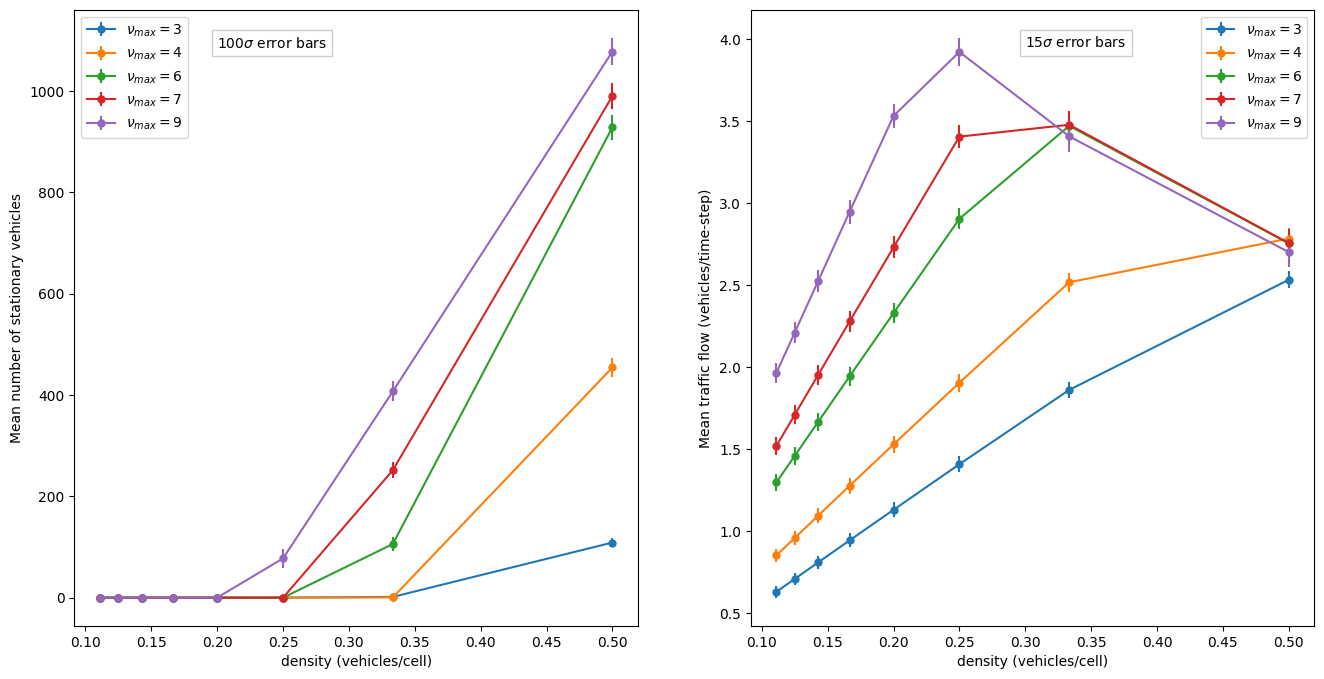

In [74]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for vmax in regular_velocities.values():
    filename = f"../Data/Regular_NaSch_vmax{vmax}.csv"
    data = pd.read_csv(filename)
    density = [1 / float(val) for val in data['cells_per_vehicle']]
    mean_stationary = data['mean_stationary']
    mean_throughput = data['mean_throughput']
    rms_stationary = [100 * sig for sig in data['rms_stationary']]
    rms_throughput = [15 * sig for sig in data['rms_throughput']]
    
    # Plot Stationary Vehicles
    ax1.errorbar(density, mean_stationary, yerr=rms_stationary, marker='o', ms=5)
    ax1.set(xlabel='density (vehicles/cell)', ylabel='Mean number of stationary vehicles')
    
    # Plot Throughput
    ax2.errorbar(density, mean_throughput, yerr=rms_throughput, marker='o', ms=5)
    ax2.set(xlabel='density (vehicles/cell)', ylabel='Mean traffic flow (vehicles/time-step)')

ax1.legend([r'$\nu_{max}=3$', r'$\nu_{max}=4$', r'$\nu_{max}=6$', r'$\nu_{max}=7$', r'$\nu_{max}=9$'])
ax1.text(0.2, 1085, r'$100\sigma$ error bars', fontsize = 10, bbox = dict(facecolor = 'white', alpha = 0.2))
ax2.legend([r'$\nu_{max}=3$', r'$\nu_{max}=4$', r'$\nu_{max}=6$', r'$\nu_{max}=7$', r'$\nu_{max}=9$'])
ax2.text(0.3, 3.95, r'$15\sigma$ error bars', fontsize = 10, bbox = dict(facecolor = 'white', alpha = 0.2))
plot_name = "../Report/Figures/Regular_NaSch.png"
f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
Image(plot_name, width=800)

clean();

In [11]:
global one_over_rho
one_over_rho = [5, 6, 7, 8]
max_velocities = list(regular_velocities.values())

In [8]:
# Generate data for possible rhos

num_vehicles = 1
N = 100000
N_vals = list(range(1, N+1))

for val in one_over_rho:

    for v_max in max_velocities:
        filename = "out.txt"
        
        generate_data(1, filename, length, v_max, p, val, num_vehicles, N)
        throughput = np.genfromtxt("throughput.txt", delimiter=',')[:-1]
        stationary = np.genfromtxt(filename, delimiter=',')[:-1]
        
        csv_name = f"../Data/Examine_rho{round(1/val, 3)}_vmax{v_max}.csv"
        with open(csv_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['N_vals', 'throughput', 'stationary'])
            for i in range(len(N_vals)):
                writer.writerow([N_vals[i], throughput[i], stationary[i]])

clean();

'Done!'

v_max: 3
stationary_mean->0.09686, throughput_mean->1.12952
stationary_rms->0.0011148963332704286, throughput_rms->0.003021413077579232

v_max: 4
stationary_mean->0.00559, throughput_mean->1.52815
stationary_rms->0.0002935785770177041, throughput_rms->0.003426717554589144

v_max: 6
stationary_mean->0.00023, throughput_mean->2.32816
stationary_rms->8.425877993100704e-05, throughput_rms->0.004125006703118785

v_max: 7
stationary_mean->0.0, throughput_mean->2.7291
stationary_rms->0.0, throughput_rms->0.004432553256902738

v_max: 9
stationary_mean->0.0, throughput_mean->3.53061
stationary_rms->0.0, throughput_rms->0.004930017579050253



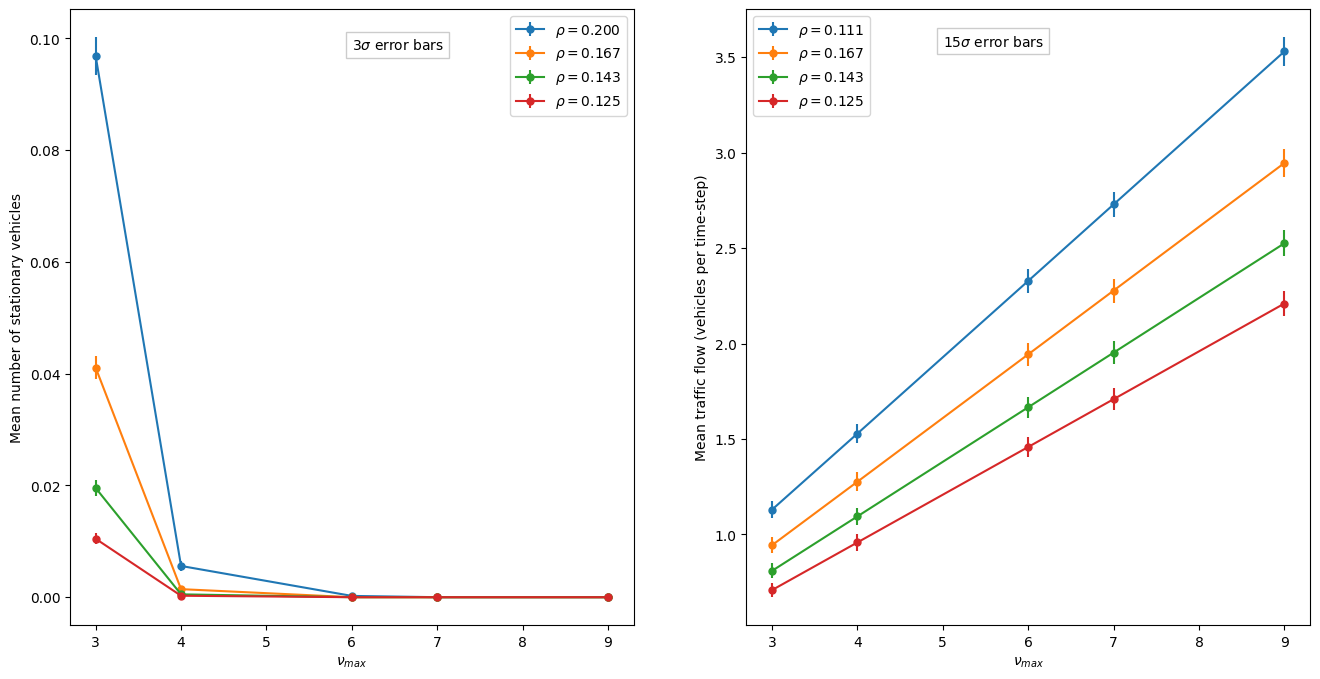

In [75]:
# Plotting for possible rhos

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for val in one_over_rho:
    stationary_mean = []
    throughput_mean = []
    stationary_bars = []
    throughput_bars = []
    for v_max in max_velocities:
        csv_name = f"../Data/Examine_rho{round(1/val, 3)}_vmax{v_max}.csv"
        data = pd.read_csv(csv_name)
        N = len(data['stationary'])
        stationary_mean.append(np.mean(data['stationary']))
        throughput_mean.append(np.mean(data['throughput']))
        stationary_rms = np.sqrt(sum((1/(N-1)) * (x - stationary_mean[-1])**2 for x in data['stationary']) / N)
        throughput_rms = np.sqrt(sum((1/(N-1)) * (x - throughput_mean[-1])**2 for x in data['throughput']) / N)
        stationary_bars.append(3 * stationary_rms)
        throughput_bars.append(15 * throughput_rms)
        if val == 5: 
            print(f"v_max: {v_max}")
            print(f"stationary_mean->{stationary_mean[-1]}, throughput_mean->{throughput_mean[-1]}")
            print(f"stationary_rms->{stationary_rms}, throughput_rms->{throughput_rms}\n")

    # Plot Stationary Vehicles
    ax1.errorbar(max_velocities, stationary_mean, yerr=stationary_bars, marker='o', ms=5)
    ax1.set(xlabel=r'$\nu_{max}$', ylabel='Mean number of stationary vehicles')

    # Plot Throughput
    ax2.errorbar(max_velocities, throughput_mean, yerr=throughput_bars, marker='o', ms=5)
    ax2.set(xlabel=r'$\nu_{max}$', ylabel='Mean traffic flow (vehicles per time-step)')

ax1.legend([r'$\rho = 0.200$', r'$\rho = 0.167$', r'$\rho = 0.143$', r'$\rho = 0.125$'])
ax1.text(6, 0.098, r'$3\sigma$ error bars', fontsize = 10, bbox = dict(facecolor = 'white', alpha = 0.2))
ax2.legend([r'$\rho = 0.111$', r'$\rho = 0.167$', r'$\rho = 0.143$', r'$\rho = 0.125$'])
ax2.text(5, 3.56, r'$15\sigma$ error bars', fontsize = 10, bbox = dict(facecolor = 'white', alpha = 0.2))
plot_name = "../Report/Figures/Examining_rho.png"
f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
Image(plot_name, width=800)

clean();


In [18]:
global bottleneck_velocities
global bottleneck_inflows
bottleneck_velocities = list(dict(json.load(open("speeds.json"))).values())
bottleneck_inflows = dict(json.load(open("../Data/inflow.json")))

In [12]:
N = 100000
N_vals = list(range(1, N+1))

for i in range(3, len(bottleneck_velocities)):
    v_max = bottleneck_velocities[i]

    filename = "out.txt"
    inflow = bottleneck_inflows[str(bottleneck_velocities[i-1])]
    
    generate_data(2, filename, length, v_max, p, inflow, N)
    throughput = np.genfromtxt("throughput.txt", delimiter=',')[:-1]
    stationary = np.genfromtxt(filename, delimiter=',')[:-1]
    
    csv_name = f"../Data/Plain_bottleneck_vmax{v_max}.csv"
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['N_vals', 'throughput', 'stationary'])
        for i in range(len(N_vals)):
            writer.writerow([N_vals[i], throughput[i], stationary[i]])

clean();

'Done!'

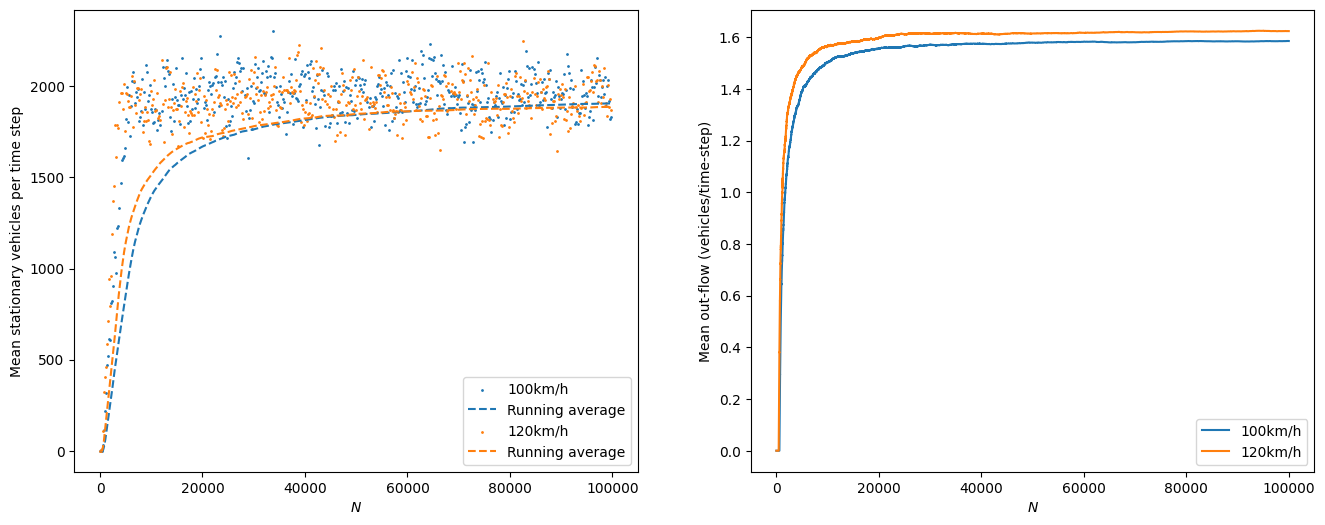

In [124]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for v_max in bottleneck_velocities[3:]:
    
    csv_name = f"../Data/Plain_bottleneck_vmax{v_max}.csv"
    data = pd.read_csv(csv_name)
    
    N_vals = data['N_vals']
    running_ave_stationary = [x / (i+1) for i, x in enumerate(np.cumsum(data['stationary']))]
    running_ave_throughput = [x / (i+1) for i, x in enumerate(np.cumsum(data['throughput']))]

    ax1.scatter(N_vals[::200], data['stationary'][::200], s=1)
    ax1.plot(N_vals, running_ave_stationary, '--')

    ax2.plot(N_vals, running_ave_throughput)
        
    plot_name = f"../Report/Figures/Plain_bottleneck.png"
    ax1.set(xlabel=r'$N$', ylabel=r'Mean stationary vehicles per time step')
    ax1.legend(['100km/h', 'Running average', '120km/h', 'Running average'])
    ax2.set(xlabel=r'$N$', ylabel=r'Mean out-flow (vehicles/time-step)')
    ax2.legend(['100km/h', '120km/h'])
    f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
    Image(plot_name, width=800)

clean();

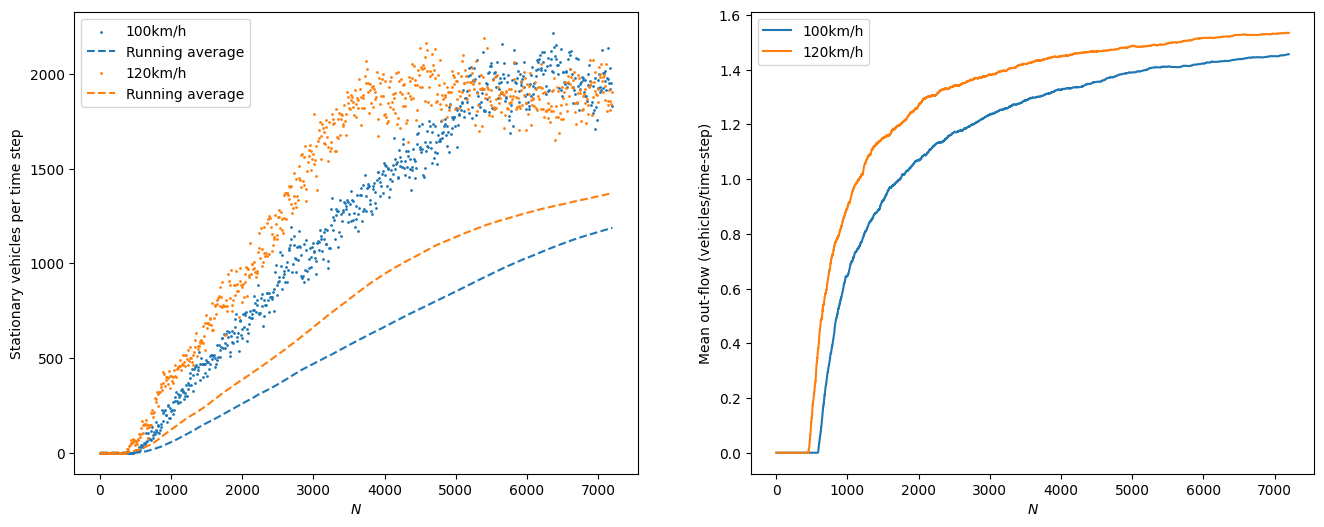

In [123]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for v_max in bottleneck_velocities[3:]:
    
    csv_name = f"../Data/Plain_bottleneck_vmax{v_max}.csv"
    data = pd.read_csv(csv_name)
    
    N_vals = data['N_vals'][:7200]
    running_ave_stationary = [x / (i+1) for i, x in enumerate(np.cumsum(data['stationary']))][:7200]
    running_ave_throughput = [x / (i+1) for i, x in enumerate(np.cumsum(data['throughput']))][:7200]
    ax1.scatter(N_vals[::10], data['stationary'][0:7200:10], s=1)
    ax1.plot(N_vals, running_ave_stationary, '--')

    ax2.plot(N_vals, running_ave_throughput)
    
plot_name = "../Report/Figures/Plain_bottleneck_4hour.png"
ax1.set(xlabel=r'$N$', ylabel=r'Stationary vehicles per time step')
ax1.legend(['100km/h', 'Running average', '120km/h', 'Running average'])
ax2.set(xlabel=r'$N$', ylabel=r'Mean out-flow (vehicles/time-step)')
ax2.legend(['100km/h', '120km/h'])
f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
Image(plot_name, width=800)

clean();

In [23]:
N = 100000
N_vals = list(range(1, N+1))
sign_dist = 1200

for i in range(3, len(bottleneck_velocities)):
    v_max = bottleneck_velocities[i]
    new_vmax = bottleneck_velocities[i-1]

    filename = "out.txt"
    inflow = bottleneck_inflows[str(new_vmax)]
    
    generate_data(3, filename, length, v_max, p, inflow, new_vmax, sign_dist, N)
    throughput = np.genfromtxt("throughput.txt", delimiter=',')[:-1]
    stationary = np.genfromtxt(filename, delimiter=',')[:-1]
    
    csv_name = f"../Data/Speedlimit_bottleneck_vmax{v_max}.csv"
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['N_vals', 'out-flow', 'stationary'])
        for i in range(len(N_vals)):
            writer.writerow([N_vals[i], throughput[i], stationary[i]])

clean();

'Done!'

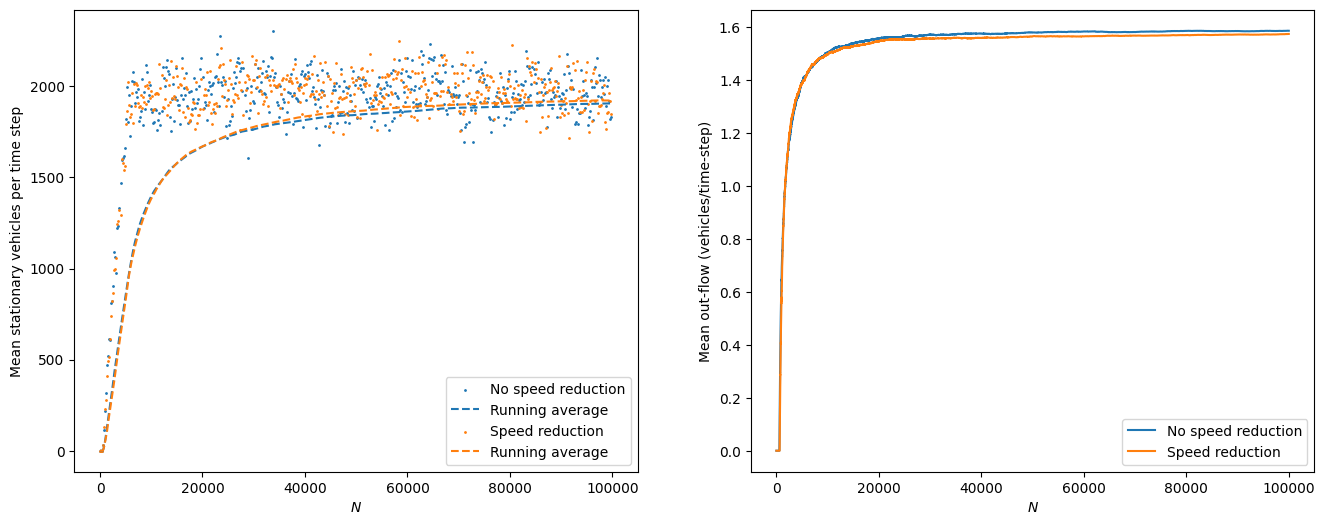

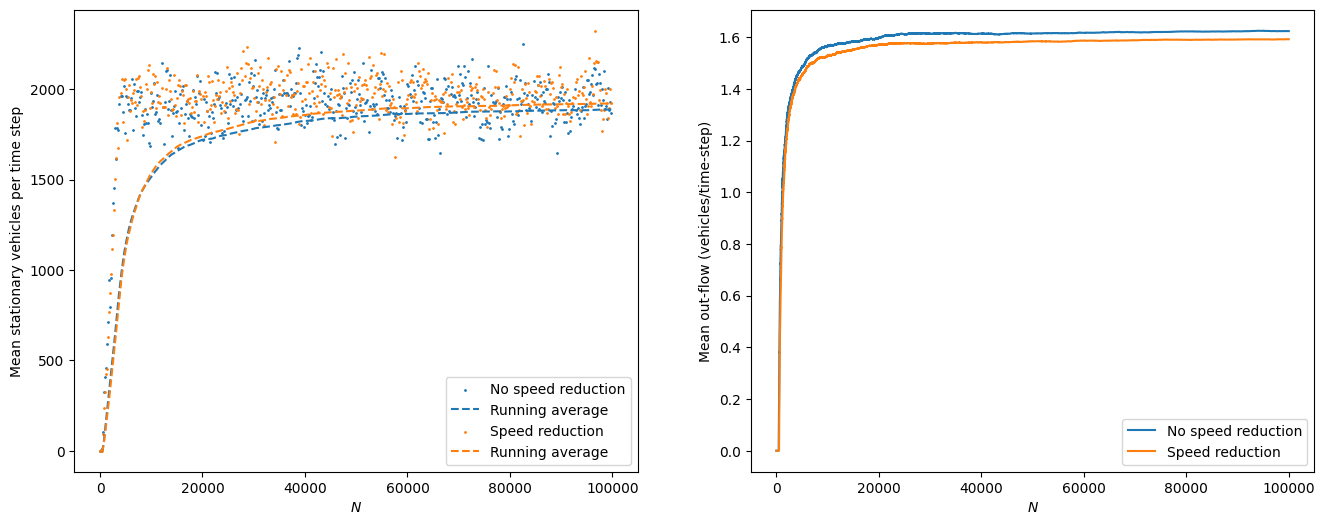

In [122]:
for v_max in bottleneck_velocities[3:]:
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    csv_name = f"../Data/Plain_bottleneck_vmax{v_max}.csv"
    data = pd.read_csv(csv_name)
    
    N_vals = data['N_vals']
    running_ave_stationary = [x / (i+1) for i, x in enumerate(np.cumsum(data['stationary']))]
    running_ave_throughput = [x / (i+1) for i, x in enumerate(np.cumsum(data['throughput']))]

    ax1.scatter(N_vals[::200], data['stationary'][::200], s=1)
    ax1.plot(N_vals, running_ave_stationary, '--')
    ax2.plot(N_vals, running_ave_throughput)
    
    csv_name = f"../Data/Speedlimit_bottleneck_vmax{v_max}.csv"
    data = pd.read_csv(csv_name)
    
    N_vals = data['N_vals']
    running_ave_stationary = [x / (i+1) for i, x in enumerate(np.cumsum(data['stationary']))]
    running_ave_throughput = [x / (i+1) for i, x in enumerate(np.cumsum(data['throughput']))]

    ax1.scatter(N_vals[::200], data['stationary'][::200], s=1)
    ax1.plot(N_vals, running_ave_stationary, '--')
    ax2.plot(N_vals, running_ave_throughput)
    
    ax1.set(xlabel=r'$N$', ylabel=r'Mean stationary vehicles per time step')
    ax1.legend(['No speed reduction', 'Running average', 'Speed reduction', 'Running average'])
    ax2.set(xlabel=r'$N$', ylabel=r'Mean out-flow (vehicles/time-step)')
    ax2.legend(['No speed reduction', 'Speed reduction'])
    plot_name = f"../Report/Figures/Speedlimit_bottleneck_vmax{v_max}.png"
    f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
    Image(plot_name, width=800)

clean();

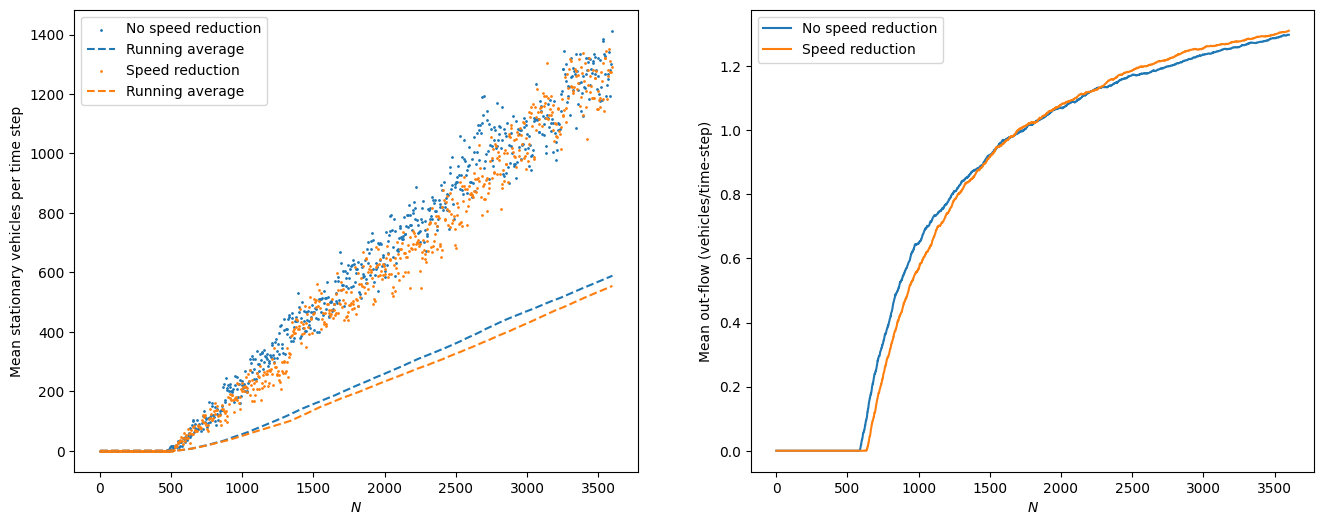

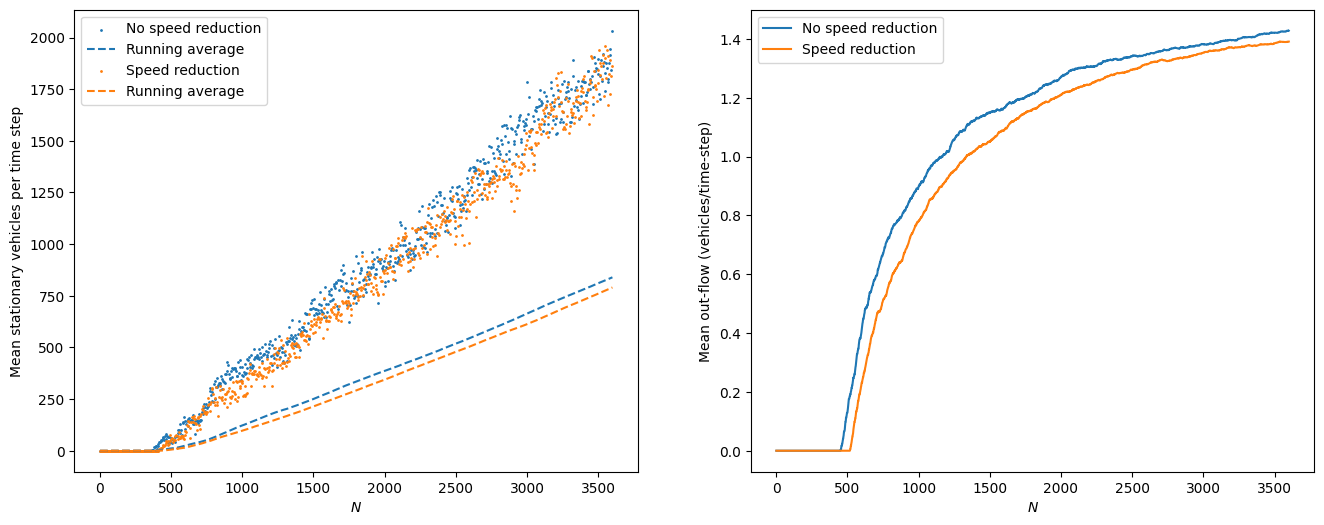

In [121]:
for v_max in bottleneck_velocities[3:]:
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    csv_name = f"../Data/Plain_bottleneck_vmax{v_max}.csv"
    data = pd.read_csv(csv_name)
    
    N_vals = data['N_vals'][:3600]
    running_ave_stationary = [x / (i+1) for i, x in enumerate(np.cumsum(data['stationary']))][:3600]
    running_ave_throughput = [x / (i+1) for i, x in enumerate(np.cumsum(data['throughput']))][:3600]

    ax1.scatter(N_vals[::5], data['stationary'][:3600:5], s=1)
    ax1.plot(N_vals, running_ave_stationary, '--')
    ax2.plot(N_vals, running_ave_throughput)
    
    csv_name = f"../Data/Speedlimit_bottleneck_vmax{v_max}.csv"
    data = pd.read_csv(csv_name)
    
    N_vals = data['N_vals'][:3600]
    running_ave_stationary = [x / (i+1) for i, x in enumerate(np.cumsum(data['stationary']))][:3600]
    running_ave_throughput = [x / (i+1) for i, x in enumerate(np.cumsum(data['throughput']))][:3600]

    ax1.scatter(N_vals[::5], data['stationary'][:3600:5], s=1)
    ax1.plot(N_vals, running_ave_stationary, '--')
    ax2.plot(N_vals, running_ave_throughput)
    
    ax1.set(xlabel=r'$N$', ylabel=r'Mean stationary vehicles per time step')
    ax1.legend(['No speed reduction', 'Running average', 'Speed reduction', 'Running average'])
    ax2.set(xlabel=r'$N$', ylabel=r'Mean out-flow (vehicles/time-step)')
    ax2.legend(['No speed reduction', 'Speed reduction'])
    plot_name = f"../Report/Figures/Speedlimit_bottleneck_vmax{v_max}_zoomed.png"
    f.savefig(plot_name, dpi=1000, transparent=False, bbox_inches='tight')
    Image(plot_name, width=800)

clean();